# Molecular Function (MF) Prediction Pipeline

This notebook implements a MLP for predicting Gene Ontology (GO) Molecular Function annotations for proteins.
Sequence information is incorporated through precomputed ProtT5 embeddings and InterPro domain features.

Make sure to change the path to a file/directory to your own path every time you see one.

### 1. Libraries and imports

In [1]:
# importing necessary packages

import os
import numpy as np
import pandas as pd
import h5py

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import pickle

### 2. Setup

In [2]:
# setting a seed
seed = 62
np.random.seed(seed)
tf.random.set_seed(seed)

### 3. Input Data

The model uses numerical feature representations of protein sequences and domain annotations.
Specific inputs are: 
- ProtT5 embeddings (raw FASTA sequences are used to generate them - );
- InterPro domain features;
- MF training labels from currated GO annotations.

In [3]:
#insert your opwn path to the data

train_dir  = "data/train/final_data" 
meta_dir   = "metadata/MF"

os.makedirs(meta_dir, exist_ok=True) # to store working files

x_path      = os.path.join(train_dir, "X_train.npy")
y_mf_path   = os.path.join(train_dir, "Y_mf_train.npy")
test_dir       = "data/test"

x_test_path    = os.path.join(test_dir, "X_test.npy")
test_ids_path  = os.path.join(test_dir, "test_ids.txt")
mf_keep_npy    = os.path.join(meta_dir, "go_terms.npy")     
go_mf_map_pkl  = os.path.join(meta_dir, "go_map.pkl")   
MF_model_path  = os.path.join(meta_dir, "MF_model.keras")
scaler_path    = os.path.join(meta_dir, "embed_scaler.pkl")
pred_out_csv   = os.path.join(meta_dir, "mf_predictions.csv")

In [4]:
# loading data

X = np.load(x_path)      # preprocessed training data = (123969,2024)
Y_mf    = np.load(y_mf_path)   # MF training labels         = (123969, 677)

print("X:", X.shape, "Y_mf:", Y_mf.shape) #checkpoint

X: (123969, 2024) Y_mf: (123969, 830)


### 4. Feature Construction

This segment has :
- Separation of InterPro domain features and ProtT5 embedding features from orignal matrix. Reasoning: InterPro domain features are binary and ProtT5 embedding features are continuous.
- MF-filtering is used to remove proteins without at least one MF-label (optional, but preferred).
- Embeddings are scaled i.e features are normalised, and a final feature matrix is created.

In [5]:
interpro_dim = 1000
embeded_dim = X.shape[1] - interpro_dim
assert embeded_dim > 0, "Embedding dimension inferred <= 0; check interpro_dim."

X_domains = X[:, :interpro_dim].astype(np.float32)  # keep as 0/1 float
X_embed   = X[:, interpro_dim:].astype(np.float32)

In [6]:
# MF label filtering

use_mf_mask = True # can be turned of, not recommended 
if use_mf_mask:
    mask = (Y_mf.sum(axis=1) > 0)
    X_domains = X_domains[mask]
    X_embed = X_embed[mask]
    Y_mf = Y_mf[mask]


In [7]:
# Normalization of embeddings

scaler = StandardScaler()
X_embed_sc = scaler.fit_transform(X_embed)

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

X_scaled = np.concatenate([X_domains, X_embed_sc], axis=1) # reassembling matrix

### 5. MF Model and Training
This segment:
- Adresses class imbalance with binary cross-entropy loss.
- Model architecture: 2 hidden layers with ReLU activation, batch normalization and dropout for regularization. An output layer with sigmoid activation function for obtaining independent probabilities for each term.
- Optimization using Adam
- Model training with an 80/20 train/validation split.

In [8]:
pos_weight=5.0
def weighted_bce(y_true, y_pred):
    # elementwise BCE
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    # upweight positives
    weights = y_true * pos_weight + (1.0 - y_true)
    return tf.reduce_mean(weights * bce)

In [9]:
# Model specification 

model = Sequential()

model.add(Dense(512, input_shape=(X_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(Y_mf.shape[1], activation='sigmoid'))

pos_weight = 5.0
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=weighted_bce)

In [10]:
# Data split

#msss makes sure all mf labels appear at least once in both train and validation sets
msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=seed
)

train_idx, val_idx = next(msss.split(X_scaled, Y_mf))

x_train = X_scaled[train_idx]
x_val   = X_scaled[val_idx]
y_train = Y_mf[train_idx]
y_val   = Y_mf[val_idx]

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)

print("Train:", x_train.shape, y_train.shape, "Val:", x_val.shape, y_val.shape)

Train: (44513, 2024) (44513, 830) Val: (11185, 2024) (11185, 830)


In [11]:
split = np.load("metadata/BP/msss_split.npz")
train_idx = split["train_idx"]
val_idx   = split["val_idx"]

In [12]:
# X_all is the full MF input matrix in original order
mf_model = tf.keras.models.load_model("metadata/MF/MF_model.keras",compile=False)
mf_probs_all = mf_model.predict(X, batch_size=1024)
# shape: (N_samples, 1466)

122/122 [==============================] - 2s 13ms/step


In [13]:
print(mf_probs_all.shape)
print(mf_probs_all.min(), mf_probs_all.max())

(123969, 830)
7.518832e-05 0.99868554


In [14]:
mf_train_probs = mf_probs_all[train_idx]
mf_val_probs   = mf_probs_all[val_idx]

np.save("metadata/MF/mf_train_probs.npy", mf_train_probs)
np.save("metadata/MF/mf_val_probs.npy", mf_val_probs)

In [15]:
# Early stoppings and Model training

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
          epochs = 50, batch_size=256,
          callbacks=callbacks,
          verbose=1)

Epoch 1/50
174/174 [==============================] - 4s 18ms/step - loss: 0.1339 - val_loss: 0.0759
Epoch 2/50
174/174 [==============================] - 3s 16ms/step - loss: 0.0761 - val_loss: 0.0656
Epoch 3/50
174/174 [==============================] - 3s 16ms/step - loss: 0.0673 - val_loss: 0.0619
Epoch 4/50
174/174 [==============================] - 3s 16ms/step - loss: 0.0628 - val_loss: 0.0597
Epoch 5/50
174/174 [==============================] - 3s 16ms/step - loss: 0.0593 - val_loss: 0.0582
Epoch 6/50
174/174 [==============================] - 3s 16ms/step - loss: 0.0568 - val_loss: 0.0572
Epoch 7/50
174/174 [==============================] - 3s 16ms/step - loss: 0.0550 - val_loss: 0.0567
Epoch 8/50
174/174 [==============================] - 3s 17ms/step - loss: 0.0532 - val_loss: 0.0562
Epoch 9/50
174/174 [==============================] - 3s 18ms/step - loss: 0.0520 - val_loss: 0.0559
Epoch 10/50
174/174 [==============================] - 3s 17ms/step - loss: 0.0505 - val_lo

In [16]:
model.save(MF_model_path)
print("Saved model to:", MF_model_path)

Saved model to: metadata/MF\MF_model.keras


In [17]:
# defininf micro f1

def micro_f1(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(np.int8)
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    return float(2 * precision * recall / (precision + recall + 1e-9))

val_prob = model.predict(x_val, batch_size=512, verbose=0)

In [18]:
# precision-recall curve on the validation set
from sklearn.metrics import precision_recall_curve

y_true = y_val.flatten()
y_score = val_prob.flatten()

precision, recall, _ = precision_recall_curve(y_true, y_score)


In [28]:
# threshold scan on validation set

thresholds = np.arange(0.01, 0.51, 0.01)
best_thr, best_score = None, -1.0
for t in thresholds:
    s = micro_f1(y_val, val_prob, t)
    if s > best_score:
        best_score = s
        best_thr = t

print("Best threshold (micro-F1 scan):", best_thr, "score:", best_score)

Best threshold (micro-F1 scan): 0.5 score: 0.6518817866899478


In [20]:
f1 = (2 * precision * recall) / (precision + recall + 1e-12)

best_idx = np.argmax(f1)
best_f1 = f1[best_idx]
best_p = precision[best_idx]
best_r = recall[best_idx]

print(f"Max micro-F1: {best_f1:.4f}")
print(f"At threshold: {best_thr:.4f}")
print(f"Precision: {best_p:.4f}, Recall: {best_r:.4f}")

Max micro-F1: 0.7048
At threshold: 0.5000
Precision: 0.7277, Recall: 0.6834


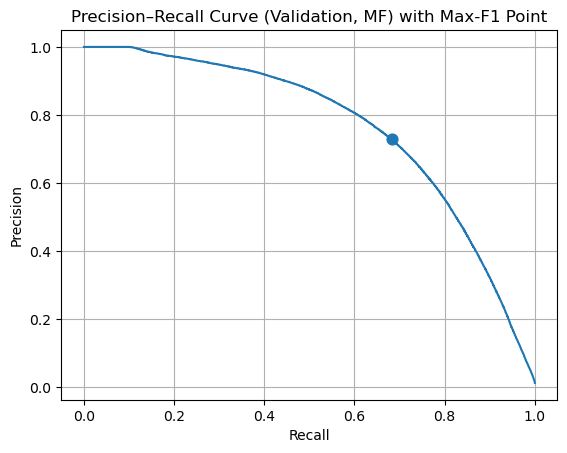

In [21]:
# Plot PR curve + mark max-F1 point
import matplotlib.pyplot as plt
plt.figure()
plt.plot(recall, precision)
plt.scatter([best_r], [best_p], s=60)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation, MF) with Max-F1 Point")
plt.grid(True)
plt.show()

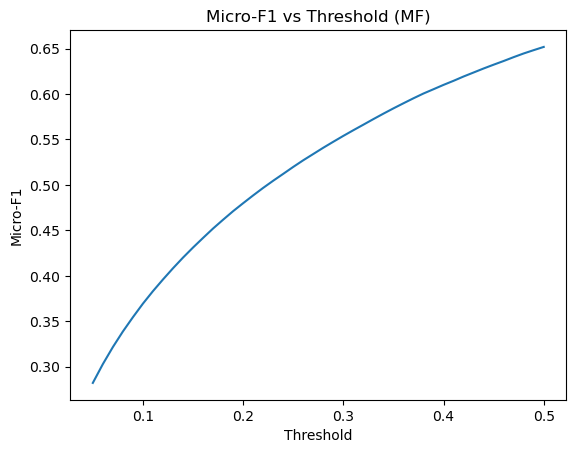

In [22]:
# checking the microF1 vs threshold relationship

scores = []
for t in thresholds:
    scores.append(micro_f1(y_val, val_prob, t))

plt.plot(thresholds, scores)
plt.xlabel("Threshold")
plt.ylabel("Micro-F1")
plt.title("Micro-F1 vs Threshold (MF)")
plt.show()

In [23]:
print("Loading:", mf_keep_npy)
print("Loading:", go_mf_map_pkl)

if not os.path.exists(mf_keep_npy):
    raise FileNotFoundError(f"Missing file: {mf_keep_npy}")

if not os.path.exists(go_mf_map_pkl):
    raise FileNotFoundError(f"Missing file: {go_mf_map_pkl}")

# Load metadata
mf_keep = np.load(mf_keep_npy, allow_pickle=True).tolist()

with open(go_mf_map_pkl, "rb") as f:
    go_mf_map = pickle.load(f)


# Final consistency check
assert len(mf_keep) == y_train.shape[1], "Mismatch: mf_keep vs Y_mf columns"
assert set(go_mf_map.values()) == set(range(len(mf_keep))), "GO index mapping is broken"

print("MF metadata loaded successfully.")

Loading: metadata/MF\go_terms.npy
Loading: metadata/MF\go_map.pkl
MF metadata loaded successfully.


### 6. Creation of a CSV for evaluating the results

In this section it is possible to find the commands to import the test data and to create a CSV file useful to evaluate the model them. The treshold for the probability prediction is set to 0.5.

In [24]:
# test data loading

X_test = np.load(x_test_path)

# metadata loading

mf_keep = np.load(f"{meta_dir}/go_terms.npy", allow_pickle=True)
with open(f"{meta_dir}/go_map.pkl", "rb") as f:
    go_mf_map = pickle.load(f)

# inverse mapping column index to GO term
inv_go_mf_map = {v: k for k, v in go_mf_map.items()}

# test ids loading

with open(test_ids_path, "r") as f:
        test_ids = [line.strip() for line in f if line.strip()]

In [25]:
# Test data normalization

# loading scaler
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

# Separating InterPro and ProtT5 features exactly as in training
interpro_dim = 1000
Xtest_domains = X_test[:, :interpro_dim].astype(np.float32)
Xtest_embed   = X_test[:, interpro_dim:].astype(np.float32)

# Scaling
Xtest_embed_scaled = scaler.transform(Xtest_embed)

# Recombining
X_test_scaled = np.concatenate(
    [Xtest_domains, Xtest_embed_scaled],
    axis=1
)

In [26]:
# Collecting predictions

seed = 62
np.random.seed(seed)
tf.random.set_seed(seed)

test_probs = model.predict(X_test_scaled, batch_size=512, verbose=1)

2/2 [==============================] - 0s 13ms/step


In [30]:
# creation of the CSV

max_protein_terms = 500   # cap of terms per sub-ontology per protein
THR = 0.5

rows = []
for i, pid in enumerate(test_ids):
    probs = test_probs[i]

    # candidate indices above threshold
    idx = np.where(probs >= THR)[0]

    # if none are above the threshold, output the top few
    if idx.size == 0:
        idx = np.argsort(-probs)[:10]

    # sort by probability
    idx = idx[np.argsort(-probs[idx])][:max_protein_terms]

    for j in idx:
        go = inv_go_mf_map[int(j)]
        score = float(probs[j])

        # enforce (0, 1.000] and avoid 0
        if score <= 0.0:
            continue
        if score > 1.0:
            score = 1.0

        # format to 3 significant figures
        score_str = f"{score:.3g}"
        rows.append((pid, go, score_str))


pred_df = pd.DataFrame(rows, columns=["Protein_ID", "GO_term", "score"])
pred_df.to_csv(pred_out_csv, index=False)
print("Saved:", pred_out_csv, "rows:", len(pred_df))

submission_txt = os.path.join (meta_dir, "mf_submission.txt")
with open(submission_txt, "w") as f:
    for pid, go, score_str in rows:
        f.write(f"{pid}\t{go}\t{score_str}\n")
        
print("Saved:", submission_txt)

Saved: metadata/MF\mf_predictions.csv rows: 14291
Saved: metadata/MF\mf_submission.txt
